In [1]:
# notebook to run tests for vnet segmentation 
# assuming first cell (git pulling leaky_vnet) from testme_cnn.ipynb has been run

# imports

import sys
sys.path.insert(0, '../00_support_functions/') # add support function directory to path
from pyfunctions import *
from leaky_vnet.model import leaky_vnet as vnet

import torch
import os, shutil
import pandas as pd
import subprocess
from subprocess import check_output, STDOUT
from collections import Counter

def seg_cnn(input, output_mask, output_mask_l="", output_mask_r="", output_box_l="", output_box_r="", thresh=0.65, logfile=""):
    '''
    Full anatomy segmentation using CNN VNET inference.

    Can output bilateral, unilateral masks, and unilaterla bounding-boxes.

    Bilateral mask (on with the unilateral outputs are based on), is trimmed by
    keeping only the 2 largest clusters.
    '''
    # prep logs
    if logfile == "":
        stdo = subprocess.DEVNULL
        stde = subprocess.DEVNULL
    else:
        stde = subprocess.STDOUT
        stdo = open(logfile, 'w')

    # load vnet
    bmriprep_cnn_seg = vnet.VNet()
    model = bmriprep_cnn_seg.from_pretrained("doggywastaken/bmri-prep_cnn_seg")
    
    ref_path = input
    ref_left = load_nii(ref_path, "left", (64,256,256))
    ref_right = load_nii(ref_path, "right", (64,256,256))
    ref = np.concatenate([ref_left, np.flip(ref_right, 2)], axis=2)

    # perform inference
    inp = torch.from_numpy(ref).view(1,1,64,256,256).float()
    pred = model( inp ).detach().numpy().squeeze()

    pred = (pred-np.min(pred))/(np.max(pred)-np.min(pred))
    mask = np.where(pred>thresh, 1, 0)
    
    # saving stuff
    npy_resize_nii(mask, input, output_mask)
    mask = mask_keep_largest2(output_mask)

    rs_mask = resize(mask, (112, 512, 512))
    msk_l = npy_bbox_nii(rs_mask, input, output_box_l, 'left')
    msk_r = npy_bbox_nii(rs_mask, input, output_box_r, 'right')

    npy_resize_nii(msk_l, input, output_mask_l)
    npy_resize_nii(msk_r, input, output_mask_r)


def seg_cnn_test(input, output_mask, thresh=0.65):
    '''
    Relatively fast anatomy segmentation using CNN VNET inference.

    Used during linear search.

    Only outputs bilateral mask, threshold can be changed.
    '''
    
    # load vnet
    bmriprep_cnn_seg = vnet.VNet()
    model = bmriprep_cnn_seg.from_pretrained("doggywastaken/bmri-prep_cnn_seg")
    
    ref_path = input
    ref_left = load_nii(ref_path, "left", (64,256,256))
    ref_right = load_nii(ref_path, "right", (64,256,256))
    ref = np.concatenate([ref_left, np.flip(ref_right, 2)], axis=2)

    # perform inference
    inp = torch.from_numpy(ref).view(1,1,64,256,256).float()
    pred = model( inp ).detach().numpy().squeeze()

    pred = (pred-np.min(pred))/(np.max(pred)-np.min(pred))
    mask = np.where(pred>thresh, 1, 0)
    
    # saving stuff
    npy_resize_nii(mask, input, output_mask)


def prepare_directory(path):
    '''
    Prepare directory.

    If directory exists, remove it and then create a new (empty) one.
    '''
    if os.path.exists(path):
        shutil.rmtree(path)
    os.makedirs(path)


def seg_cnn_linsearch(input, output_dir, range1=0.90, range2=0.60, nrtests=7, logfile=""):
    '''
    Linear search of output threshold parameter for CNN VNET anatomy segmentation output.

    Output threshold ranges [0,1]. Performs linear search in range
    [range1,range2], totallying nrtests number of tests.

    Parametrics are determined here. Currently looked at parameters:

    1) Minimize:
        Third cluster size.
        Assumed to be the largest "noise" cluster).
    2) Maximize: 
        Second largest cluster (breast cluster) size - 
        Third largest cluster (largest "noise" cluster) size.
    3) Minimize: Number of clusters 
        Minus the 2 largest clusters, which are unilateral breasts clusters,
        this should reflect the number of noise clusters in the segmentation

    Final reported "optimal" threshold value is determined through majority
    voting of each of the above parameters.
    '''

    # prep logs
    if logfile == "":
        stdo = subprocess.DEVNULL
        stde = subprocess.DEVNULL
    else:
        stde = subprocess.STDOUT
        stdo = open(logfile, 'w')


    input_basename = os.path.basename(input)
    input_basename_noext = os.path.splitext(input_basename)[0]
    output_directory = os.path.join(output_dir, input_basename_noext)

    prepare_directory(output_directory) 

    thresholds = [round(x, 2) for x in np.linspace(range1,range2,nrtests)]
    parametrics = np.zeros((nrtests, 4))
    parametrics[:,0] = thresholds
    c = 0
    for i in tqdm(thresholds):
        nr_as_str = str(i)
        nr_as_str = nr_as_str.replace("0.", "p")
        output_mask  = output_directory + '/' + input_basename_noext + '_' + nr_as_str + '_Mask.nii' 
        seg_cnn_test(input, output_mask, thresh=i)
        parametrics[c, 1:4] = afni_clusterize(output_mask)
        c += 1

    # majority vote of evaluate parameters

    # minimum of "third cluster"
    #v1 = parametrics[np.argmin(parametrics[:,1]), 0]
    # maximum of "breast cluster - noise cluster" delta
    #v2 = parametrics[np.argmax(parametrics[:,2]), 0]
    # minimum of nubmer of noise clusters
    #v3 = parametrics[np.argmin(parametrics[:,3]), 0]
    #params = [v1, v2, v3]
    #counter = Counter(params) 
    #majority = max(counter, key=counter.get)

    #print("parametric threshold by majority vote: ", majority)

    #shutil.rmtree(output_dir)

    #return majority
    return parametrics


def afni_clusterize(input):
    '''
    Performs clustering using AFNI's 3dClusterize program.

    Generate (temporary) report, reads reports and calculates relevant
    parameters based on the cluster report
    '''

    stdo = subprocess.DEVNULL
    stde = subprocess.DEVNULL
    cmd = "3dClusterize -inset " + input + " -ithr 0 -idat 0 -NN 1 -within_range 0 1 -clust_nvox 40 -quiet > tmp_report.txt"
    cmd2 = "sed \'s/ \\+/\\t/g\' tmp_report.txt > tmp_report_tab.txt"
    
    try:
        cmd_stdout = check_output(cmd, stderr=STDOUT, shell=True).decode()
    except Exception as e:
        print(e.output.decode())
        print(e)

    try:
        cmd_stdout = check_output(cmd2, stderr=STDOUT, shell=True).decode()
    except Exception as e:
        print(e.output.decode())
        print(e)

    param1, param2, param3 = calc_parameter()
    subprocess.run(['rm tmp_report.txt tmp_report_tab.txt'], shell=True, check=True, stdout=stdo, stderr=stde)
    return param1, param2, param3


def calc_parameter():
    '''
    Separated function just to calculate parametrics based on cluster
    statistics.

    See seg_cnn_linsearch() documentation for parameter definitions and details.
    '''

    tmp_clustTable = pd.read_csv('tmp_report_tab.txt', delimiter='\t', header=None)
    tmp_clustTable = tmp_clustTable.iloc[:, 1:-1]
    clustTable = tmp_clustTable.to_numpy()

    # calculating parametrics
    # param1: size of the third cluster
    param1 = clustTable[2, 0]

    # param2: size difference between the second and third cluster
    param2 = clustTable[1, 0] - clustTable[2, 0]
    
    # param3: number of clusters
    param3 = clustTable.shape[0]

    return param1, param2, param3


def mask_keep_largest2(input):
    '''
    Use AFNI's 3dClusterize to filter a (bilateral) segmentation mask
    (from CNN VNET), by only keeping the largest two clusters.  
    '''

    # list commands
    cmd = "3dClusterize -inset " + input + " -ithr 0 -idat 0 -NN 1 -within_range 0 1 -clust_nvox 40 -quiet -pref_map ClustMap.nii"
    cmd2 = "3dcalc -a ClustMap.nii -expr 'within(a,1,2)' -prefix threshedMap.nii" 
    cmd3 = "rm ClustMap.nii"
    cmd4 = "mv threshedMap.nii " + input

    try:
        cmd_stdout = check_output(cmd, stderr=STDOUT, shell=True).decode()
    except Exception as e:
        print(e.output.decode())
        print(e)

    try:
        cmd_stdout = check_output(cmd2, stderr=STDOUT, shell=True).decode()
    except Exception as e:
        print(e.output.decode())
        print(e)

    subprocess.call(cmd3, shell=True)
    subprocess.call(cmd4, shell=True)

    outp = nib.load(input).get_fdata()

    return outp


def seg_cnn_opt(input_data, output_mask, output_mask_l="", output_mask_r="", output_box_l="", output_box_r=""):
    '''
    Anatomy segmentation using CNN VNET inference.

    Output threshold is parametrically optimized through linear search on
    output cluster parameters.

    Final output is thresholded to keep the two largest clusters.
    '''
    thr = seg_cnn_linsearch(input_data, r'tmpdir/')
    seg_cnn(input_data, output_mask, output_mask_l, output_mask_r, output_box_l, output_box_r, thresh=thr)

In [2]:
# final cell for easy integration into the main pipeline, 
# only a single wrapper script to call parametrically optimized segmentation
# using CNN is required.

input_data = r'../evaldata/sub-020/ses-01/sub-020_ses-01_ref.nii'
eval_data_tmp_dir = r'cnn_linsearch/'

params = seg_cnn_linsearch(input_data, eval_data_tmp_dir)

100%|██████████| 7/7 [01:23<00:00, 11.89s/it]


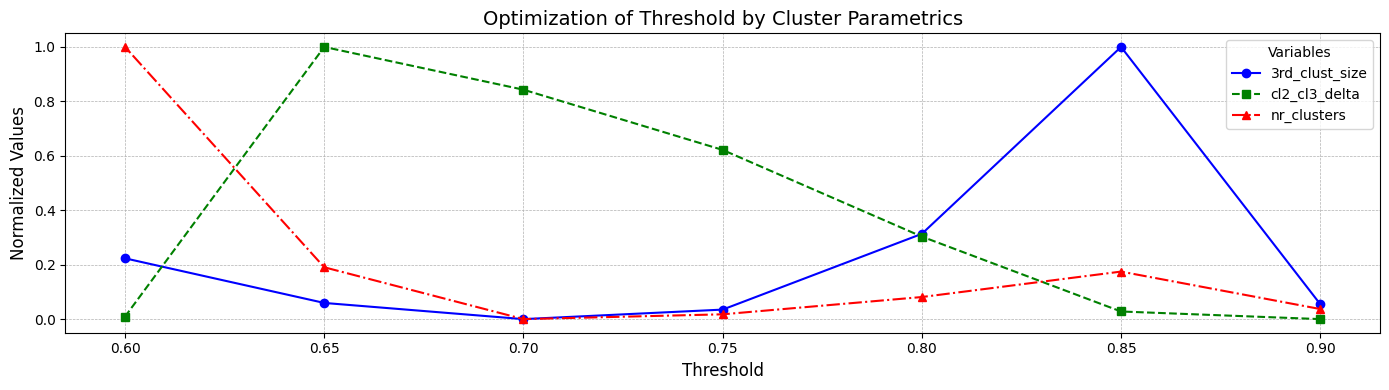

In [3]:
import pandas as pd
from matplotlib import pyplot as plt
params_df  = pd.DataFrame(data=params, columns=["threshold", "3rd_clust_size", "cl2_cl3_delta", "nr_clusters"])
#params_df = (params_df - params_df.min()) / (params_df.max() - params_df.min())

# Normalize only columns 2-4 (excluding 'threshold')
for col in ["3rd_clust_size", "cl2_cl3_delta", "nr_clusters"]:
    params_df[col] = (params_df[col] - params_df[col].min()) / (params_df[col].max() - params_df[col].min())


# Plot the normalized data with distinct colors for better clarity
plt.figure(figsize=(14, 4))
plt.plot(params_df['threshold'], params_df['3rd_clust_size'], label='3rd_clust_size', marker='o', linestyle='-', color='blue')
plt.plot(params_df['threshold'], params_df['cl2_cl3_delta'], label='cl2_cl3_delta', marker='s', linestyle='--', color='green')
plt.plot(params_df['threshold'], params_df['nr_clusters'], label='nr_clusters', marker='^', linestyle='-.', color='red')

# Add labels, title, and legend
plt.xlabel('Threshold', fontsize=12)
plt.ylabel('Normalized Values', fontsize=12)
plt.title('Optimization of Threshold by Cluster Parametrics', fontsize=14)
plt.legend(title='Variables', fontsize=10)

# Improve grid and style
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()

# Display the plot
plt.show()